<a href="https://colab.research.google.com/github/LeSaUi/DLtest/blob/main/nlp_from_scratch_generating_names_with_a_character_level_rnn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2023-07-07 08:09:00--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.39.6, 18.65.39.75, 18.65.39.56, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.39.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.02s   

2023-07-07 08:09:00 (111 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating

In [11]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
  )

# Read a file and split into lines
def readLines(filename):
  with open(filename, encoding='utf-8') as some_file:
    return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories += [category]
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
  raise RuntimeError('Data not found.'
  'Make sure that you downloaded data from https://download.pytorch.org/tutorial/data.zip '
  'and extract it to the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Scottish', 'Dutch', 'Greek', 'Vietnamese', 'French', 'English', 'Japanese', 'German', 'Polish', 'Czech', 'Irish', 'Chinese', 'Arabic', 'Italian', 'Spanish', 'Portuguese', 'Korean', 'Russian']
O'Neal


In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)

    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)

    output_combined = torch.cat((hidden,output), 1)
    output = self.o2o(output_combined)

    output = self.dropout(output)
    output = self.softmax(output)
    return output,hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)


In [13]:
import random

# Random item from a list
def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

In [14]:
# One-hot vector for category
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

# ''LongTensor'' of second letter to end (EOS) for target
def targetTensor(line):
  letter_indexes = [all_letters.find(c) for c in line[1:]]
  letter_indexes += [n_letters - 1] # EOS
  return torch.LongTensor(letter_indexes)


In [15]:
# Make category, input and target tensors from a random (category, line) pair
def randomTrainingExample():
  category, line = randomTrainingPair()
  return categoryTensor(category), inputTensor(line), targetTensor(line)

In [16]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.initHidden()

  rnn.zero_grad()

  loss = torch.Tensor([0]) # you can also just simply use ''loss = 0''

  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss += l

  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item() / input_line_tensor.size(0)

In [17]:
import time

def timeSince(since):
  now = time.time()
  s = now - since
  m = s // 60
  s %= 60
  return f'{m}m:{s}s'


In [18]:
rnn = RNN(n_letters, 128 ,n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ''plot_every'' ''iters''

start = time.time()

for iter in range(1, n_iters + 1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss

  if iter % print_every == 0:
    print(f'{timeSince(start)} ({iter} {iter / n_iters * 100}%) {loss:.4f}')

  if iter % plot_every == 0:
    all_losses += [total_loss / plot_every]
    total_loss = 0

0.0m:16.095821380615234s (5000 5.0%) 3.4577
0.0m:32.05907988548279s (10000 10.0%) 2.6432
0.0m:48.029712200164795s (15000 15.0%) 2.6777
1.0m:4.619293451309204s (20000 20.0%) 2.1780
1.0m:20.71407651901245s (25000 25.0%) 2.7070
1.0m:36.70852780342102s (30000 30.0%) 2.4894
1.0m:53.299036502838135s (35000 35.0%) 2.4120
2.0m:9.59039044380188s (40000 40.0%) 2.6213
2.0m:25.332457065582275s (45000 45.0%) 1.5112
2.0m:41.19497084617615s (50000 50.0%) 2.0896
2.0m:57.842018604278564s (55000 55.00000000000001%) 1.8150
3.0m:13.823346138000488s (60000 60.0%) 2.6203
3.0m:29.900392055511475s (65000 65.0%) 2.4752
3.0m:45.64850115776062s (70000 70.0%) 2.3236
4.0m:3.2473349571228027s (75000 75.0%) 2.5137
4.0m:19.069778442382812s (80000 80.0%) 2.8692
4.0m:35.03455710411072s (85000 85.0%) 1.8776
4.0m:50.700456619262695s (90000 90.0%) 1.0375
5.0m:7.434188604354858s (95000 95.0%) 1.8366
5.0m:23.332834482192993s (100000 100.0%) 1.5624


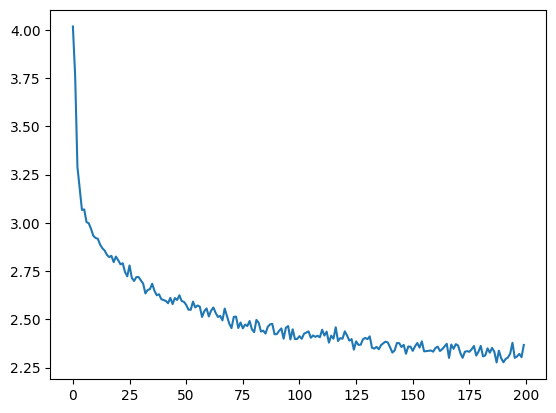

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [20]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
  with torch.no_grad(): # no need to track history in sampling
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Rovani
Uanton
Shanaki
Gerren
Eanger
Romer
Salla
Parer
Allana
Chan
Hain
Iung
